In [1]:
import json
import tensorflow as tf
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
def isSarcastic(prediction, sentence):
    if len(prediction) > 1:
        for i, v in enumerate(prediction):
            if v > 0.5:
                print("\n", sentence[i], "-> is Funny:", str(v[0]*100) + "%")
            else:
                print("\n", sentence[i], "-> is Not Funny:", str(v[0]*100) + "%")
    else:
        if prediction > 0.5:
            print("\n", sentence, "-> is Funny:", prediction)
        else:
            print("\n", sentence, "-> is Not Funny:", prediction)

In [16]:
DESIRED_ACCURACY = 0.949999
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy')>DESIRED_ACCURACY):
            print(f"\nReached {DESIRED_ACCURACY * 100}% accuracy so cancelling training!", )
            self.model.stop_training = True

In [17]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

In [18]:
data = pd.read_csv('dataset.csv')
data_size = len(data)

In [19]:
data

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False
...,...,...
199995,Conor maynard seamlessly fits old-school r&b h...,False
199996,How to you make holy water? you boil the hell ...,True
199997,How many optometrists does it take to screw in...,True
199998,Mcdonald's will officially kick off all-day br...,False


In [20]:
sentences = data['text']
labels = data['humor']

In [21]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [26]:
num_epochs = 30
callbacks = myCallback()
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[callbacks])

Epoch 1/30
625/625 - 11s - loss: 0.5327 - accuracy: 0.7799 - val_loss: 0.2979 - val_accuracy: 0.8861 - 11s/epoch - 17ms/step
Epoch 2/30
625/625 - 9s - loss: 0.2304 - accuracy: 0.9154 - val_loss: 0.2172 - val_accuracy: 0.9154 - 9s/epoch - 15ms/step
Epoch 3/30
625/625 - 12s - loss: 0.1780 - accuracy: 0.9338 - val_loss: 0.2095 - val_accuracy: 0.9151 - 12s/epoch - 19ms/step
Epoch 4/30
625/625 - 10s - loss: 0.1516 - accuracy: 0.9438 - val_loss: 0.1885 - val_accuracy: 0.9262 - 10s/epoch - 15ms/step
Epoch 5/30

Reached 94.9999% accuracy so cancelling training!
625/625 - 9s - loss: 0.1306 - accuracy: 0.9532 - val_loss: 0.1859 - val_accuracy: 0.9269 - 9s/epoch - 15ms/step


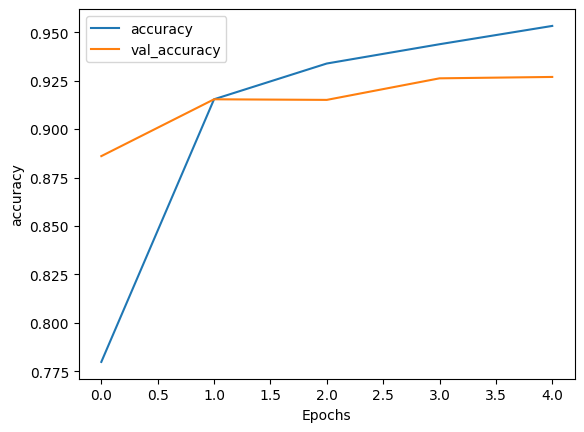

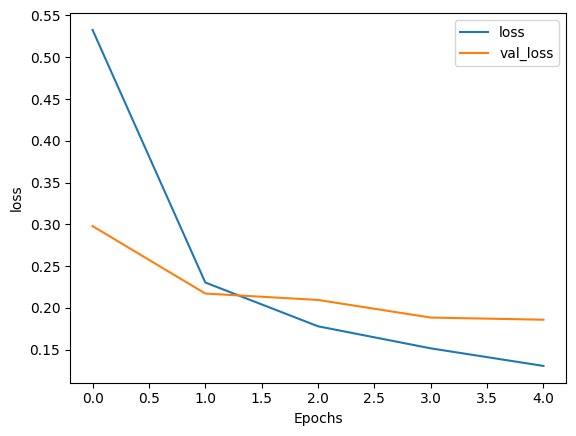

In [27]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [28]:
sentence = [
    'My wife told me to stop impersonating a flamingo. I had to put my foot down.',
    'I went to buy some camo pants but couldn’t find any.',
    'I failed math so many times at school, I can’t even count.',
    'Did you know that the boomerang is Australias biggest export? Its also their biggest import.',
    'Don’t you hate it when someone answers their own questions? I do.',
    'Germany is the second most populous country in Europe after Russia.',
    "Cost of living calculations are also used to compare the cost of maintaining a certain standard of living in different geographic areas.",
    "Along with Hong Kong, South Korea, and Taiwan, Singapore is one of the Four Asian Tigers, and has surpassed its peers in terms of Gross Domestic Product (GDP) per capita.",
    "Nowadays Italy is the fifth most visited country in international tourism.",
    "This TF Hub model uses the implementation of BERT from the TensorFlow Models repository on GitHub."
]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
isSarcastic(model.predict(padded), sentence)

1/1 [==============================] - 0s 100ms/step

 My wife told me to stop impersonating a flamingo. I had to put my foot down. -> is Funny: 99.69378113746643%

 I went to buy some camo pants but couldn’t find any. -> is Funny: 99.7625470161438%

 I failed math so many times at school, I can’t even count. -> is Funny: 98.25621247291565%

 Did you know that the boomerang is Australias biggest export? Its also their biggest import. -> is Funny: 97.56947755813599%

 Don’t you hate it when someone answers their own questions? I do. -> is Funny: 96.61077857017517%

 Germany is the second most populous country in Europe after Russia. -> is Not Funny: 5.993002653121948%

 Cost of living calculations are also used to compare the cost of maintaining a certain standard of living in different geographic areas. -> is Not Funny: 7.839864492416382%

 Along with Hong Kong, South Korea, and Taiwan, Singapore is one of the Four Asian Tigers, and has surpassed its peers in terms of Gross Domestic Pr